
### Exercício 4.2

O programa `Python` seguinte implementa o algoritmo de bubble sort para ordenação in situ de um array de inteiros `seq`.

In [ ]:
seq = [-2,1,2,-1,4,-4,-3,3]
changed = True
# pre
assert changed = True and len(seq) >= 0
while changed:
    changed = False
    for i in range(len(seq) - 1):
        if seq[i] > seq[i+1]:
            seq[i], seq[i+1] = seq[i+1], seq[i]
            changed = True
# pos
assert forall i . 0 <= i < n -> seq[i] <= seq[i+1] and assert changed = False

pass            


1. Defina a pré-condição e a pós-condição que descrevem a especificação deste algoritmo.
2. O ciclo `for` pode ser descrito por uma transição $\,\mathtt{seq}\gets \mathit{exp}(\mathtt{seq})\,$. Construa uma relação de transição $\;\mathsf{trans}(\mathtt{seq},\mathtt{seq}')\,$ que modele esta atribuição.
3. Usando a técnica que lhe parecer mais conveniente verifique a correção do algoritmo.


### 1. Pré e Pós Condição


* Pré-Condição: $$ changed = True \land N >= 0 \land N < len(array) -1$$
* Pós-Condição: $$ changed = False \land \forall_{i<N-1}\,\centerdot\, seq[i] \gt seq[i+1]$$

### 2. Definição do ciclo for como uma transição
O ciclo for pode ser representado por uma relação de transição. O esquema seguinte representa o sistema de transição:

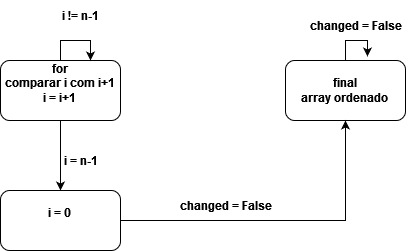

### 3. Correção do programa
Para a correção do programa utilizamos a técnica SAU (Single Assignment Unfold).

### Classe SAU

In [1]:
from pysmt.shortcuts import *
from pysmt.typing import *

# Auxiliares
def prime(v):
    return Symbol("next(%s)" % v.symbol_name(), v.symbol_type())
def fresh(v):
    return FreshSymbol(typename=v.symbol_type(),template=v.symbol_name()+"_%d")

# A classe "Sigle Assignment Unfold"
class SAU(object):
    """Trivial representation of a while cycle and its unfolding."""
    def __init__(self, variables, pre , pos, control, trans, sname="z3"):
              
        self.variables = variables       # variables   
        self.pre = pre                   # pre-condition as a predicate in "variables"
        self.pos = pos                   # pos-condition as a predicate in "variables"
        self.control = control           # cycle control as a predicate in "variables"
        self.trans = trans               # cycle body as a binary transition relation 
                                         # in "variables" and "prime variables"
        
        self.prime_variables = [prime(v) for v in self.variables]
        self.frames = [And([Not(control),pos])]  
                 # inializa com uma só frame: a da terminação do ciclo
        
        self.solver = Solver(name=sname)

    def new_frame(self):        
        freshs = [fresh(v) for v in self.variables]    
        b = self.control
        S = self.trans.substitute(dict(zip(self.prime_variables,freshs)))
        W = self.frames[-1].substitute(dict(zip(self.variables,freshs)))
        
        self.frames.append(And([b , ForAll(freshs, Implies(S, W))]))
        
    def unfold(self,bound=0):
        n = 0
        while True:
            if n > bound:
                print("falha: número de tentativas ultrapassa o limite %d "%bound)
                break
            
            f = Or(self.frames)
            if self.solver.solve([self.pre,Not(f)]):  
                self.new_frame()
                n += 1
            else:
                print("sucesso na tentativa %d "%n)
                break   
    
    

In [2]:
# constantes auxiliares
array = [-2,1,2,-1,4,-4,-3,3]

seq = Symbol("seq", ArrayType(INT, INT))

for j in range(len(array)):
    Store(seq, Int(j), Int(array[j]))

changed_pre = Bool(True)
changed_pos = Bool(False)

# O ciclo
i = Symbol("i", INT)
temp = Symbol("temp", INT)
N = Symbol("N", INT)
changed = Symbol("changed")
variables = [i, changed, N, temp, seq]

pre  =  And(                                                         # pré-condição    
    Iff(changed,changed_pre),                                        # changed = True
    GE(N, Int(0)),                                                   # N >= 0
    LT(N, Minus(Int(len(array)), Int(1)) )                           # N < tamanho do array -1
)     

pos  =  And(
    GE(i, Int(0)), LT(i, Minus(N, Int(1))),                         # i >= 0, i < N -1
    ForAll([i], LE(Select(seq, i), Select(seq, Plus(i, Int(1)) ))), # forall i, seq[i] <= seq[i+1]
    Iff(changed, changed_pos)                                       # changed = False
)       

cond =  Iff(changed, changed_pre)                                   # condição de controlo do ciclo

trans_for = And(
    ForAll(
        [i],
        And(
            LT(i, Minus(N, Int(1))),  # i < n -1
            GE(i, Int(0)),
            Implies(
                GT( Select(seq, i), Select(seq, Plus(i, Int(1))) ),   # if (seq[i] > seq[i+1])
                And(  # swap
                    Equals(temp, Select(seq, i)),
                    Equals(Select(seq,i), Select(seq, Plus(i, Int(1)))),
                    Equals(Select(seq, Plus(i, Int(1))), temp),
                    Iff(changed, changed_pre)
                )
            )
        )
    )
)

trans_while = And(                           # corpo do ciclo como uma relaçao de transição
    Iff(changed, changed_pos),
    trans_for
)

W = SAU(variables, pre, pos, cond, trans_while)
#Run
W.unfold(len(array))

sucesso na tentativa 1 
